In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import random
from tqdm import tqdm
from pathlib import Path
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, optimizers, losses, metrics, callbacks, initializers
from tensorflow.keras import Sequential, Model, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, MobileNetV2, VGG16
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

from keras.utils.vis_utils import plot_model

from PIL import Image
import warnings
warnings.filterwarnings("ignore")
random.seed(45)

print(tf.__version__)

2.6.4


In [2]:
import glob
import os
from tqdm import tqdm
from PIL import  Image, ImageFile
from joblib  import Parallel, delayed
import shutil
ImageFile.LOAD_TRUNCATED_IMAGES = True

LOAD IMAGE DATA AND UNDERSTANDING SOME PROPERTIES OF IMAGE

In [3]:
def image_properties(path):
    for img in random.sample(os.listdir(path),1):
        print('Image name =',img)
        image = cv.imread(os.path.join(path, img),cv.IMREAD_COLOR)
        break
        
    return image

Image name = 102084.jpg
The dimensions are 640 pixels height and 480 pixels width
The maximum pixel value is 255.00
The minimum pixel value is 0.00
The mean value of the pixels is 104.00
The standard deviation is 74.08


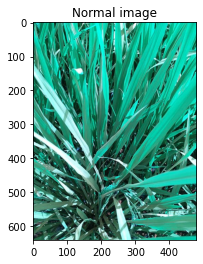

In [4]:
path = '../input/paddy-disease-classification/train_images/normal'

image = image_properties(path)
plt.imshow(image)
plt.title('Normal image')
print(f"The dimensions are {image.shape[0]} pixels height and {image.shape[1]} pixels width")
print(f"The maximum pixel value is {image.max():.2f}")
print(f"The minimum pixel value is {image.min():.2f}")
print(f"The mean value of the pixels is {image.mean():.2f}")
print(f"The standard deviation is {image.std():.2f}")

Loading a dataset

In [5]:
batch_size = 64
img_height = 256
img_width =  256

data_dir ='../input/paddy-disease-classification/train_images'

Image Data-Generator

Data Normalization And Data Augmentation

In [6]:
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                            rescale=1.0/255.0,
                            validation_split=0.3,
                            rotation_range=5,
                            shear_range=0.3,
                            zoom_range=0.3,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True
                )

Training Dataset (70%)

In [7]:
train_gen = img_datagen.flow_from_directory(
                            data_dir,
                            subset="training",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                            class_mode="categorical",
                            color_mode='rgb'
            )

Found 7288 images belonging to 10 classes.


Testing Dataset (30%)

In [8]:
valid_gen = img_datagen.flow_from_directory(
                            data_dir,
                            subset="validation",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                            class_mode="categorical"
            )

Found 3119 images belonging to 10 classes.


Class Lables

In [9]:
print('Total No Of Classes in the datasetL:',len(train_gen.class_indices))
print('Class Names:',train_gen.class_indices)

Total No Of Classes in the datasetL: 10
Class Names: {'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}


Displaying a 9 Random images form dataset

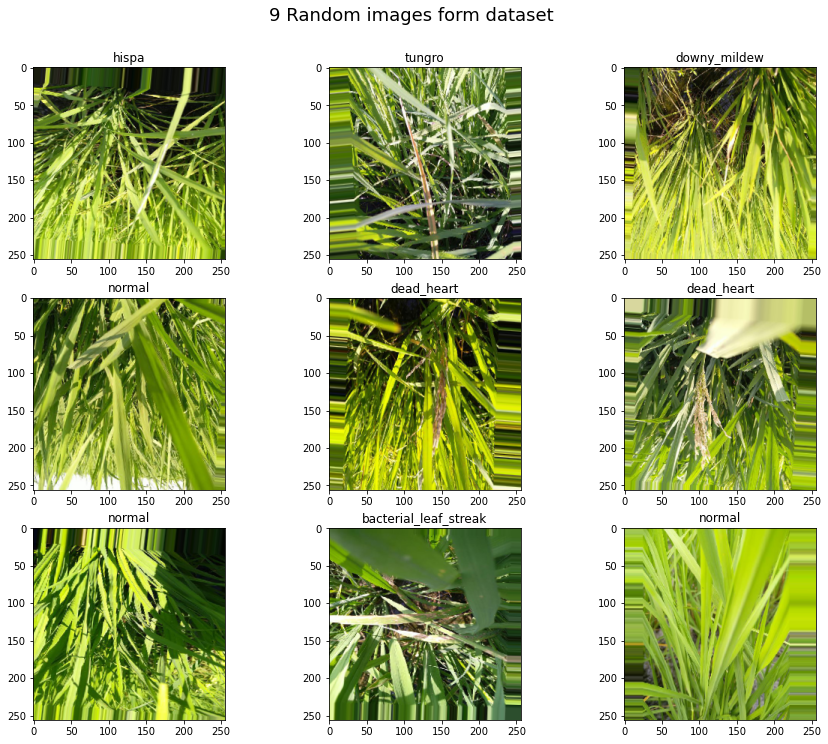

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
plt.subplots_adjust(hspace=0.2)
fig.suptitle("9 Random images form dataset", fontsize=18, y=0.95)

for i in range(1,10):
    plt.subplot(3,3,i)
    img, label = train_gen.next()
    plt.title(list(train_gen.class_indices.keys())[np.argmax(label)])
    plt.imshow(img[0])
     

InceptionV3

In [11]:
model_inception = None
model_inception = InceptionV3(include_top = False, input_shape = (256,256,3), weights = '/kaggle/input/weights-inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

model_inception.trainable = True

inputs = Input(shape=(256,256,3))
main = model_inception(inputs, training = True)

x = layers.Flatten()(main)
x = layers.Dense(256, 'relu', kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(10, activation='softmax', name= 'outputs')(x)

model_inception = Model(inputs= [inputs], outputs= [outputs])


model_inception.compile(optimizer=optimizers.Adam(3e-4), 
              metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)], 
              loss=losses.CategoricalCrossentropy(label_smoothing=0.1))

model_inception.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               18874624  
_________________________________________________________________
batch_normalization_94 (Batc (None, 256)               1024      
_________________________________________________________________
outputs (Dense)              (None, 10)                2570      
Total params: 40,681,002
Trainable params: 40,646,058
Non-trainable params: 34,944
____________________________________________

In [12]:

# terminate if loss was NaN
class TerminateNaN(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    loss = logs.get('loss')
    if loss is not None:
      if np.isnan(loss) or np.isinf(loss):
        print('Invalid loss and terminated at loss {}'.format(epoch))
        self.model.stop_training = True

terminate_nan = TerminateNaN()

In [13]:
# save model after every epoch if the validation accuracy improves from previous epoch
filepath = '/kaggle/working/every_epoch'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    monitor="val_categorical_accuracy",
    verbose=1,
    save_best_only=True,
    mode = 'auto'
)

In [14]:
# learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_categorical_accuracy",
    factor=0.1,
    patience=1,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=3,
    min_lr=0
)

In [15]:
history = model_inception.fit(
    train_gen,
    batch_size = batch_size,
    validation_data = valid_gen,
    epochs=20,
    verbose=1,
    callbacks=[terminate_nan, checkpoint, reduce_lr]
)

Epoch 1/20
114/114 [==============================] - 314s 3s/step - loss: 1.5696 - categorical_accuracy: 0.5720 - val_loss: 1.3844 - val_categorical_accuracy: 0.7198

Epoch 00001: val_categorical_accuracy improved from -inf to 0.71978, saving model to /kaggle/working/every_epoch
Epoch 2/20
114/114 [==============================] - 219s 2s/step - loss: 0.9725 - categorical_accuracy: 0.8133 - val_loss: 0.9447 - val_categorical_accuracy: 0.8464

Epoch 00002: val_categorical_accuracy improved from 0.71978 to 0.84643, saving model to /kaggle/working/every_epoch
Epoch 3/20
114/114 [==============================] - 217s 2s/step - loss: 0.8051 - categorical_accuracy: 0.8913 - val_loss: 0.8393 - val_categorical_accuracy: 0.8859

Epoch 00003: val_categorical_accuracy improved from 0.84643 to 0.88586, saving model to /kaggle/working/every_epoch
Epoch 4/20
114/114 [==============================] - 219s 2s/step - loss: 0.7108 - categorical_accuracy: 0.9319 - val_loss: 0.7691 - val_categorical_a

                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.03      0.03      0.03       143
   bacterial_leaf_streak       0.04      0.04      0.04       114
bacterial_panicle_blight       0.03      0.03      0.03       101
                   blast       0.17      0.17      0.17       521
              brown_spot       0.08      0.08      0.08       289
              dead_heart       0.12      0.12      0.12       432
            downy_mildew       0.05      0.05      0.05       186
                   hispa       0.13      0.13      0.13       478
                  normal       0.16      0.16      0.16       529
                  tungro       0.09      0.09      0.09       326

                accuracy                           0.12      3119
               macro avg       0.09      0.09      0.09      3119
            weighted avg       0.11      0.12      0.11      3119



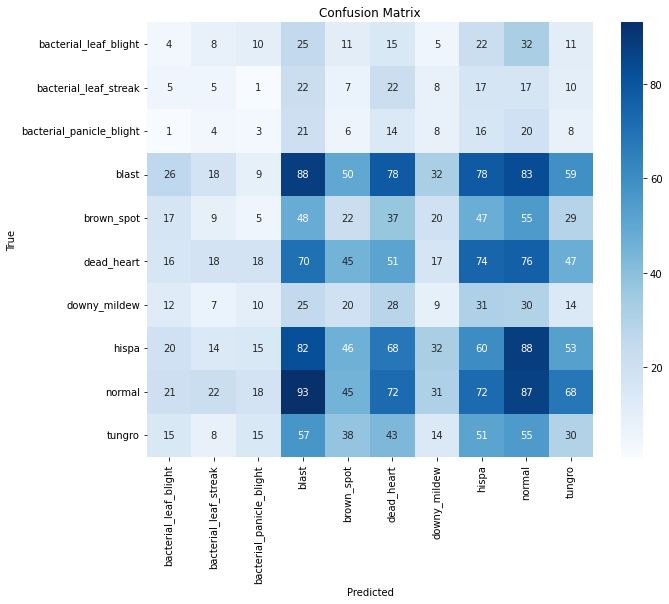

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = model_inception.predict(valid_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = valid_gen.classes

class_names = list(valid_gen.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=class_names))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

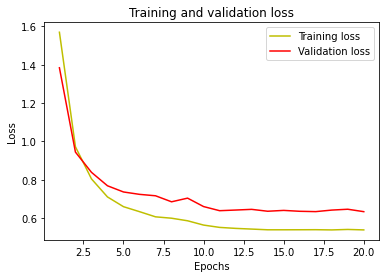

In [17]:
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

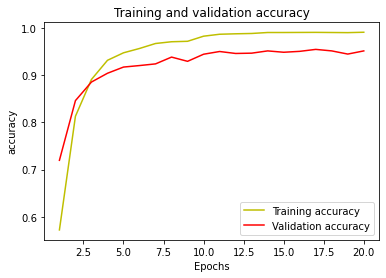

In [21]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [22]:
loss, accuracy = model_inception.evaluate(valid_gen)

49/49 [==============================] - 67s 1s/step - loss: 0.6405 - categorical_accuracy: 0.9487


In [24]:
print('Validation Accuracy', accuracy)

Validation Accuracy 0.9487015008926392


In [26]:
model_inception.save('/kaggle/working/model.h5')